In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from torchvision.models.feature_extraction import create_feature_extractor
from ipywidgets import fixed, interactive, widgets 
%matplotlib inline

In [2]:
#Helper methods
def to_torch(x):
    return torch.from_numpy(x).float()


def to_numpy(x):
    return x.detach().numpy()


def plot_data(X, y, X_test, y_test):
    clip_bound = 2.5
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.scatter(X[:, 0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, y_test, '--', color='royalblue', linewidth=2.0, label='Ground truth')


def plot_relu(bias, slope):
    plt.scatter([-bias / slope], 0, c='darkgrey', s=40.0)
    if slope > 0 and bias < 0:
        plt.plot([0, -bias / slope, 1], [0, 0, slope * (1 - bias)], ':')
    elif slope < 0 and bias > 0:
        plt.plot([0, -bias / slope, 1], [-bias * slope, 0, 0], ':')


def plot_relus(params):
    slopes = to_numpy(params[0]).ravel()
    biases = to_numpy(params[1])
    for relu in range(biases.size):
        plot_relu(biases[relu], slopes[relu])


def plot_function(X_test, net):
    y_pred = net(to_torch(X_test))
    plt.plot(X_test, to_numpy(y_pred), '-', color='forestgreen', label='prediction')


def plot_update(X, y, X_test, y_test, net, state=None):
    if state is not None:
        net.load_state_dict(state)
    plt.figure(figsize=(10, 7))
    plot_relus(list(net.parameters()))
    plot_function(X_test, net)
    plot_data(X, y, X_test, y_test)
    plt.legend()
    plt.show();


def train_network(X, y, X_test, y_test, net, optim, n_steps, save_every, initial_weights=None, verbose=False):
    loss = torch.nn.MSELoss()
    y_torch = to_torch(y.reshape(-1, 1))
    X_torch = to_torch(X)
    if initial_weights is not None:
        net.load_state_dict(initial_weights)
    history = {}
    for s in range(n_steps):
        subsample = np.random.choice(y.size, y.size // 5)
        step_loss = loss(y_torch[subsample], net(X_torch[subsample, :]))
        optim.zero_grad()
        step_loss.backward()
        optim.step()
        if (s + 1) % save_every == 0 or s == 0:
#             plot_update(X, y, X_test, y_test, net)
            history[s + 1] = {}
            history[s + 1]['state'] = copy.deepcopy(net.state_dict())
            with torch.no_grad():
                test_loss = loss(to_torch(y_test.reshape(-1, 1)), net(to_torch(X_test)))
            history[s + 1]['train_error'] = to_numpy(step_loss).item()
            history[s + 1]['test_error'] = to_numpy(test_loss).item()
            if verbose:
                print("SGD Iteration %d" % (s + 1))
                print("\tTrain Loss: %.3f" % to_numpy(step_loss).item())
                print("\tTest Loss: %.3f" % to_numpy(test_loss).item())
            else:
                # Print update every 10th save point
                if (s + 1) % (save_every * 10) == 0:
                    print("SGD Iteration %d" % (s + 1))

    return history


def plot_test_train_errors(history):
    sample_points = np.array(list(history.keys()))
    etrain = [history[s]['train_error'] for s in history]
    etest = [history[s]['test_error'] for s in history]
    plt.plot(sample_points / 1e3, etrain, label='Train Error')
    plt.plot(sample_points / 1e3, etest, label='Test Error')
    plt.xlabel("Iterations (1000's)")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()
    plt.show();


def make_iter_slider(iters):
    # print(iters)
    return widgets.SelectionSlider(
        options=iters,
        value=1,
        description='SGD Iterations: ',
        disabled=False
    )


def history_interactive(history, idx, X, y, X_test, y_test, net):
    plot_update(X, y, X_test, y_test, net, state=history[idx]['state'])
    plt.show()
    print("Train Error: %.3f" % history[idx]['train_error'])
    print("Test Error: %.3f" % history[idx]['test_error'])


def make_history_interactive(history, X, y, X_test, y_test, net):
    sample_points = list(history.keys())
    return interactive(history_interactive,
                       history=fixed(history),
                       idx=make_iter_slider(sample_points),
                       X=fixed(X),
                       y=fixed(y),
                       X_test=fixed(X_test),
                       y_test=fixed(y_test),
                       net=fixed(net))

# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

_Once you have gone through the discussion once you may wish to adjust the number of training samples and noise variance to see how gradient descent behaves under the new conditions._

In [3]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
    
n_features = 1
n_samples = 200
sigma = 0.1
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

_Once you have gone through the discussion once you may wish to train networks with even larger widths to see how they behave under the three different training paradigms in this notebook._

In [5]:
# Don't rerun this cell after training or you will lose all your work
nets_by_size = {}

In [6]:
widths = [10, 20, 40]
for width in widths:
    # Define a 1-hidden layer ReLU nonlinearity network
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    loss = nn.MSELoss()
    # Get trainable parameters
    weights_all = list(net.parameters())
    # Get the output weights alone
    weights_out = weights_all[2:]
    # Adjust initial biases so elbows are in [0,1]
    elbows = np.sort(np.random.rand(width))
#     print("Elbows located at:")
#     print(elbows)
    new_biases = -elbows * to_numpy(weights_all[0]).ravel()
    weights_all[1].data = to_torch(new_biases)
    # Create SGD optimizers for outputs alone and for all weights
    lr_out = 0.2
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
    opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
    # Save initial state for comparisons
    initial_weights = copy.deepcopy(net.state_dict())
    # print("Initial Weights", initial_weights)
    nets_by_size[width] = {'net': net, 'opt_all': opt_all, 
                           'opt_out': opt_out, 'init': initial_weights}

## Visualize Gradients
(a) Visualize the features corresponding to the gradients of the first hidden layer’s weights and the first
hidden layer’s biases.

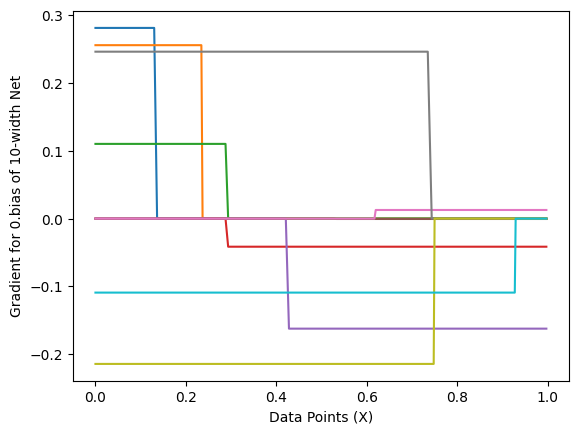

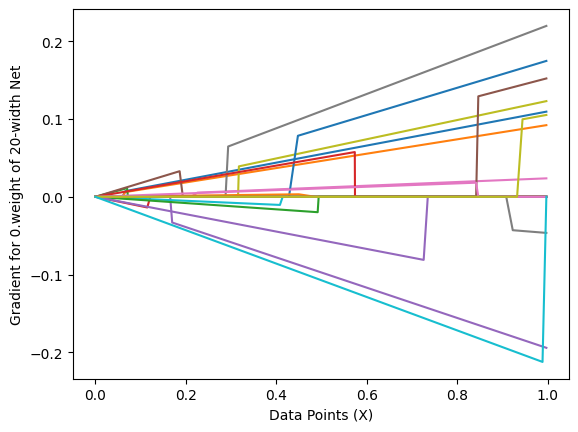

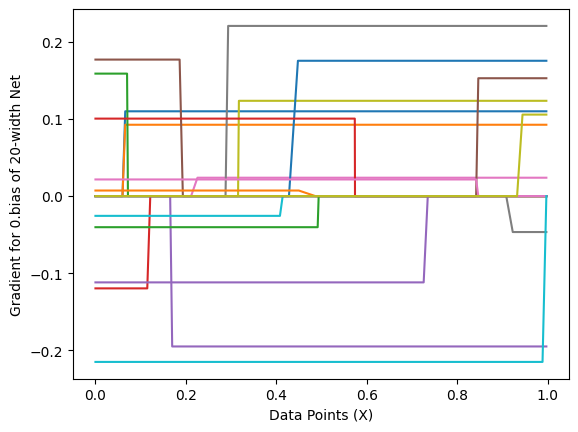

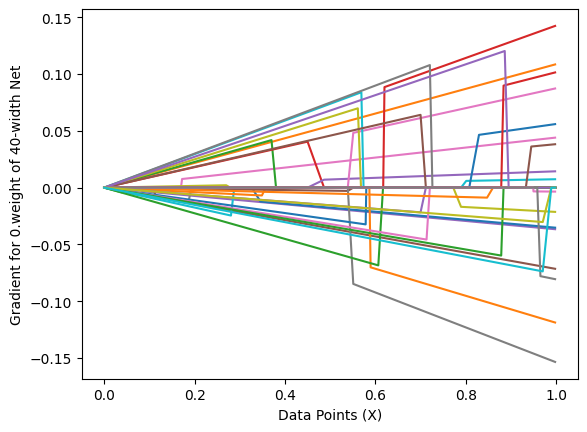

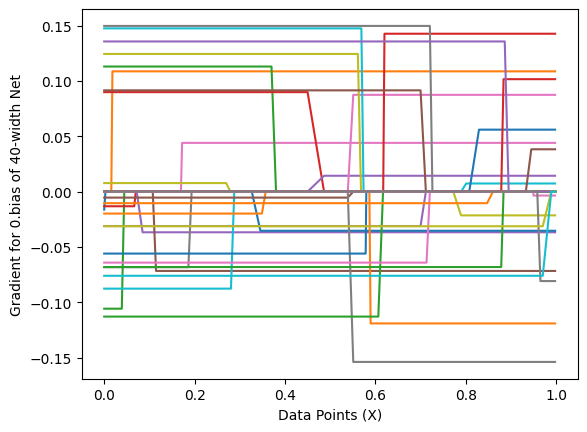

In [54]:

def backward_and_plot_grad(X, net, vis_name='all', legend=False):
    width = net[0].out_features #the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    # X = sorted(X)
    for x in X:
        model = nets_by_size[width]['net']
        y = model(to_torch(x))
        y.backward()
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.data.reshape(-1) ):
                
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                if vis_name == 'all' or vis_name == n:
                    if f'{n}.{w_idx}' not in vis_collect: vis_collect[f'{n}.{w_idx}'] = True
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
        model.zero_grad()
    
    for w_n in vis_collect:
        plt.plot( X, gradient_collect[w_n]['y'], label=w_n )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Gradient for {vis_name} of {width}-width Net')
    if legend: plt.legend()
    plt.show()

for width in nets_by_size:
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.weight')
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.bias')

## SVD for feature matrix
(b) Use the SVD of this feature matrix to plot both the singular values and visualize the “principle
features” that correspond to the d-dimensional singular vectors multiplied by all the features
corresponding to the parameters

Width 10
(200, 31)


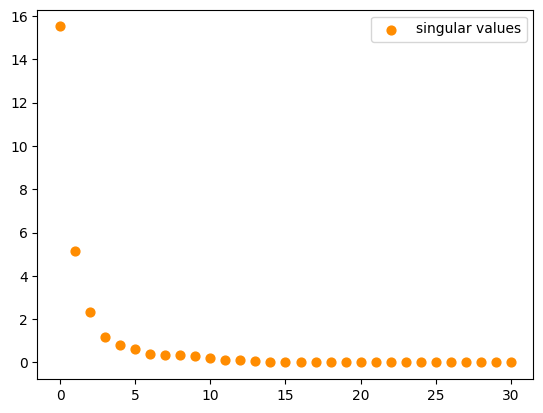

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


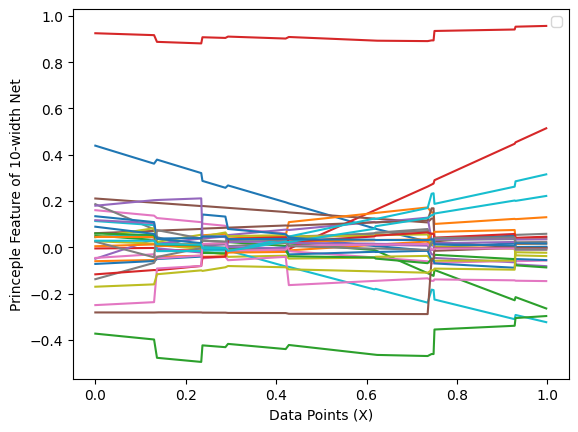

Width 20
(200, 61)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


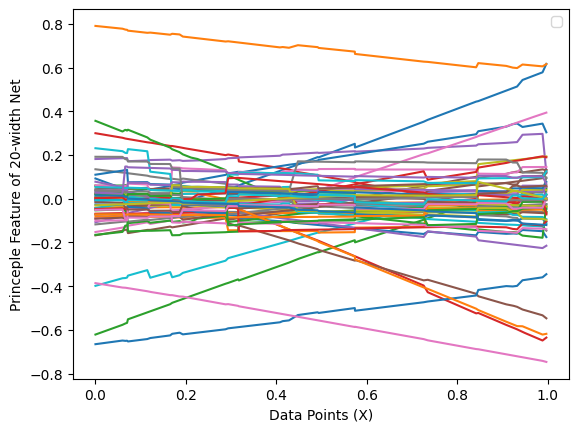

Width 40
(200, 121)


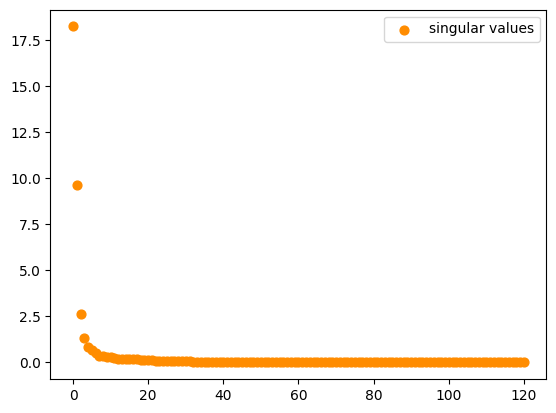

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


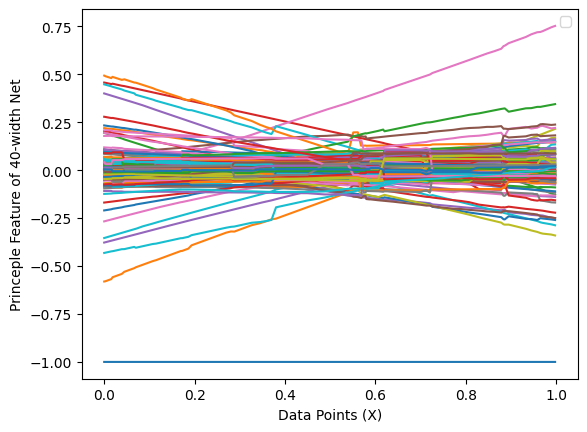

In [55]:
def compute_svd_plot_features(X, y, X_test, y_test, net):
    width = net[0].out_features #the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    # X = sorted(X)
    for x in X:
        model = nets_by_size[width]['net']
        y = model(to_torch(x))
        y.backward()
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
        model.zero_grad()

    feature_matrix = []
    for w_n in gradient_collect:
        feature_matrix.append( gradient_collect[w_n]['y'] )
    feature_matrix = np.array( feature_matrix ).T
    print(feature_matrix.shape)
    u, s, vh = np.linalg.svd(np.array( feature_matrix ), full_matrices=False)
    plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label='singular values')
    plt.legend()
    plt.show()

    # construct more training matrix 
    princple_feature = feature_matrix @ vh
    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, princple_feature.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net')
    plt.legend()
    plt.show()

for w in widths:
    net = nets_by_size[w]['net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)


## Different Initialization
(c) With a different random initialization for the network, all the individual features will change quite
significantly.  When the network has a significant number of hidden units,
do the principle features change more or less than any individual specific feature?

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 31)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


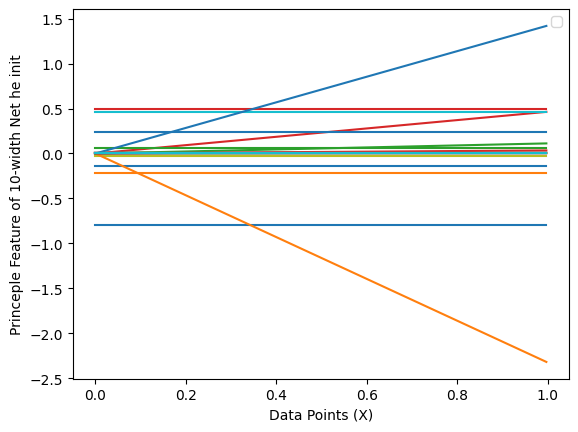

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 31)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


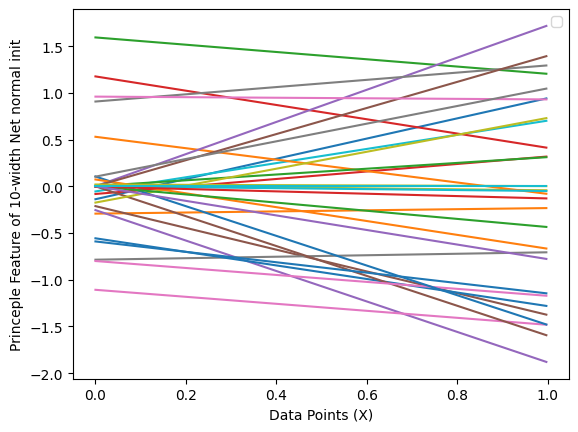

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 31)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


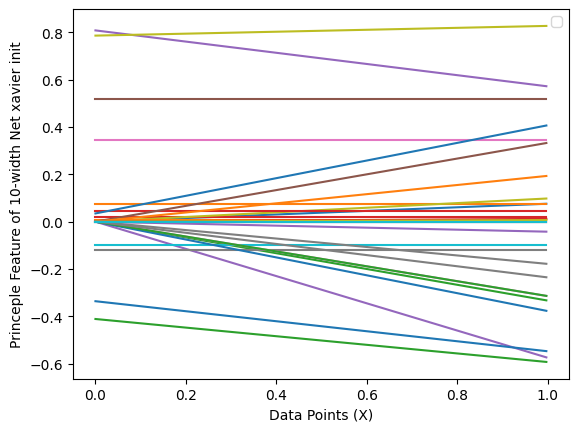

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 61)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


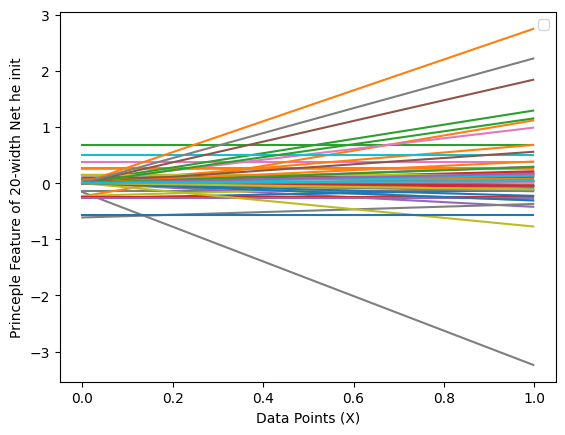

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 61)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


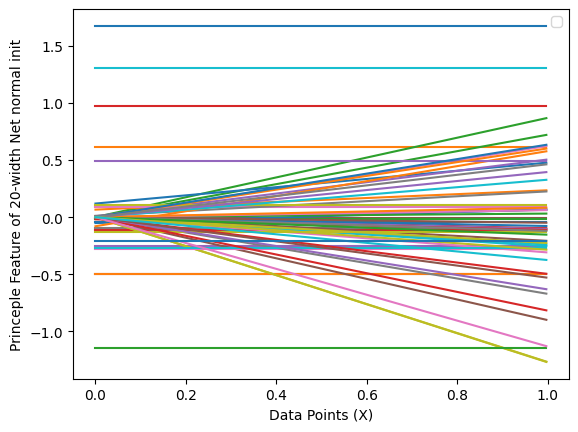

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 61)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


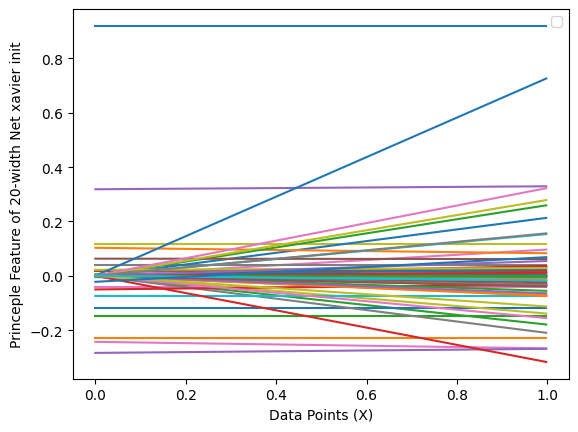

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 121)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


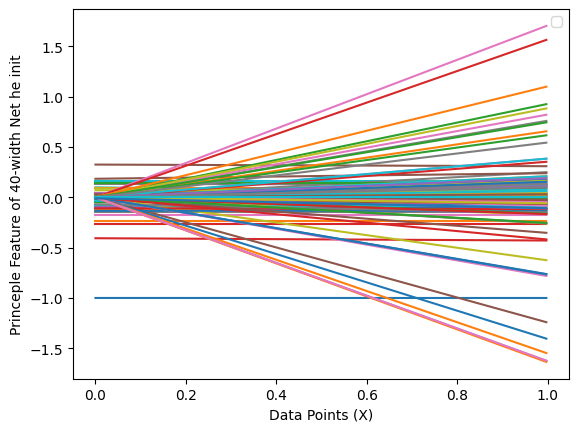

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 121)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


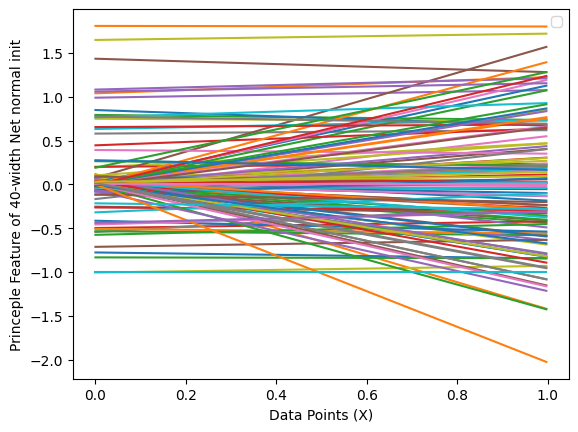

Width Parameter containing:
tensor([0.], requires_grad=True)
(200, 121)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [66]:
def compute_svd_plot_features(X, y, X_test, y_test, net, label=''):
    width = net[0].out_features #the width is the number of hidden units.
    # gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    # X = sorted(X)
    for x in X:
        model = net
        y = model(to_torch(x))
        y.backward()
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
        model.zero_grad()

    feature_matrix = []
    for w_n in gradient_collect:
        feature_matrix.append( gradient_collect[w_n]['y'] )
    feature_matrix = np.array( feature_matrix ).T
    print(feature_matrix.shape)
    u, s, vh = np.linalg.svd(np.array( feature_matrix ), full_matrices=False)
    # plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label=f'singular values {label}')
    # plt.legend()
    # plt.show()

    # construct more training matrix 
    princple_feature = feature_matrix @ vh
    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, princple_feature.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net {label}')
    plt.legend()
    plt.show()

initializations = ['he', 'normal', 'xavier']
widths = [10, 20, 40]
for width in widths:
    for initialization in initializations:
        # net = nets_by_size[w]['net']
        net = nn.Sequential(nn.Linear(1, width),
                            nn.ReLU(),
                            nn.Linear(width, 1))
        for w in net.parameters():
            if len(w.shape) > 1:
                if initialization == 'he':
                    torch.nn.init.kaiming_normal_(w, nonlinearity='relu')
                elif initialization == 'zero':
                    torch.nn.init.zeros_(w)
                elif initialization == 'normal':
                    torch.nn.init.normal_(w)
                elif initialization == 'xavier':
                    torch.nn.init.xavier_normal_(w)
            else:
                torch.nn.init.zeros_(w)
        print("Width", w)
        compute_svd_plot_features(X, y, X_test, y_test, net,  label=f'{initialization} init')


## Two-layer Network
(d) Augment the jupyter notebook to add a second hidden layer of the same size as the first hidden layer,
fully connected to the first hidden layer using He initialzation for the initial condition of the weights
and Xavier intialization for the initial condition of the biases. Enhance the code you have already
written to allow the visualization of the features corresponding to the parameters in both hidden
layers, as well as the “principle features” and the singular values

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Linear(in_features=1, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=1, bias=True)
)
torch.Size([10]) torch.Size([1, 10])
torch.Size([1]) torch.Size([1, 1])
(200, 20)
(200, 20)


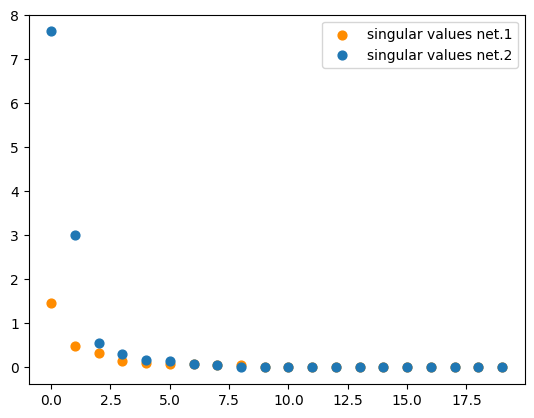

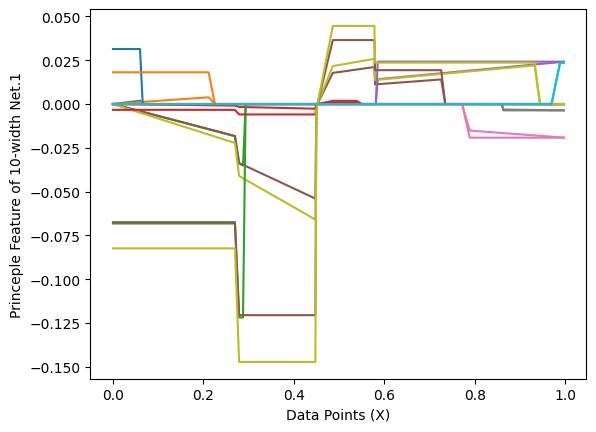

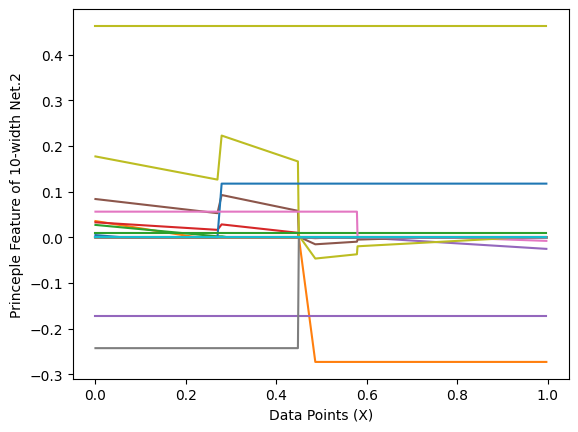

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=1, bias=True)
  (3): Linear(in_features=1, out_features=20, bias=True)
  (4): ReLU()
  (5): Linear(in_features=20, out_features=1, bias=True)
)
torch.Size([20]) torch.Size([1, 20])
torch.Size([1]) torch.Size([1, 1])
(200, 40)
(200, 40)


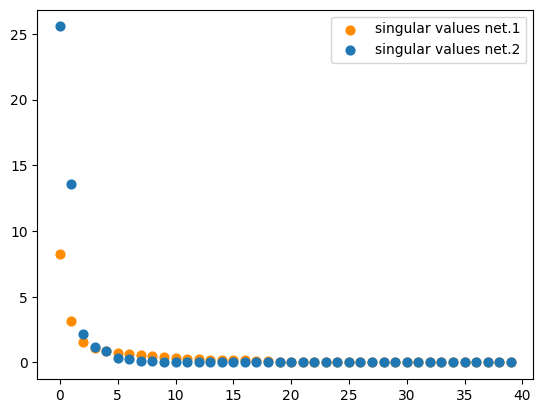

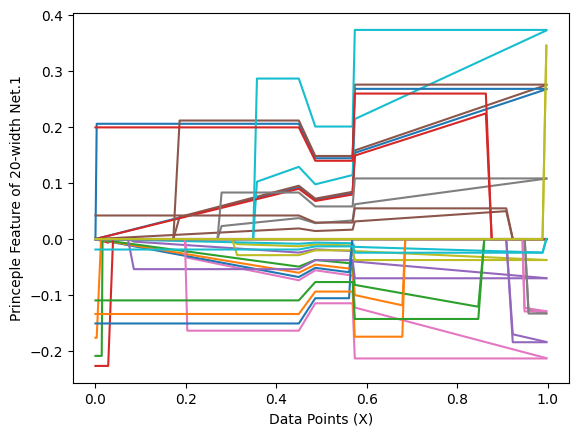

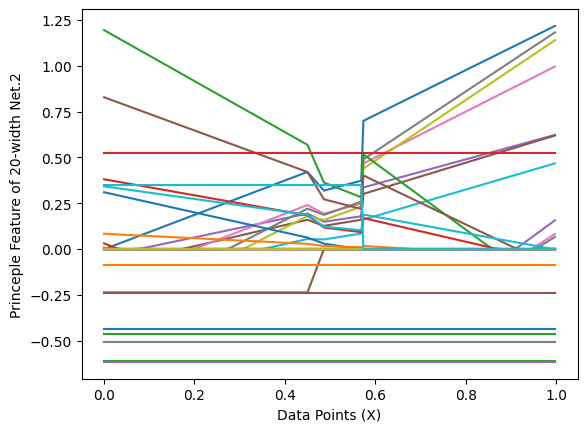

Sequential(
  (0): Linear(in_features=1, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): Linear(in_features=1, out_features=40, bias=True)
  (4): ReLU()
  (5): Linear(in_features=40, out_features=1, bias=True)
)
torch.Size([40]) torch.Size([1, 40])
torch.Size([1]) torch.Size([1, 1])
(200, 80)
(200, 80)


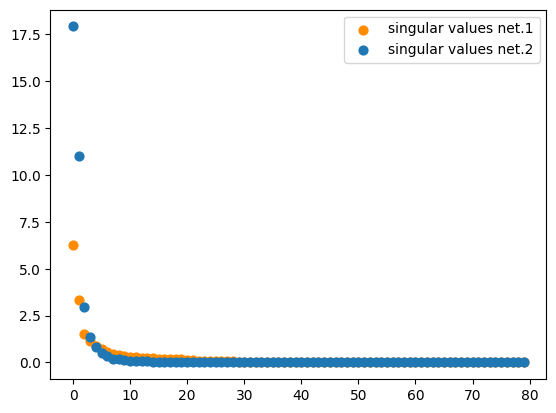

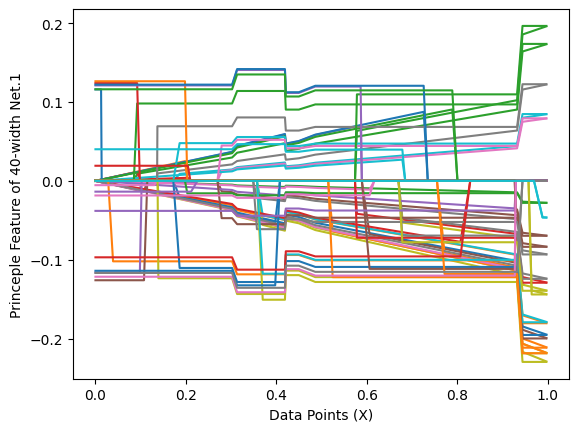

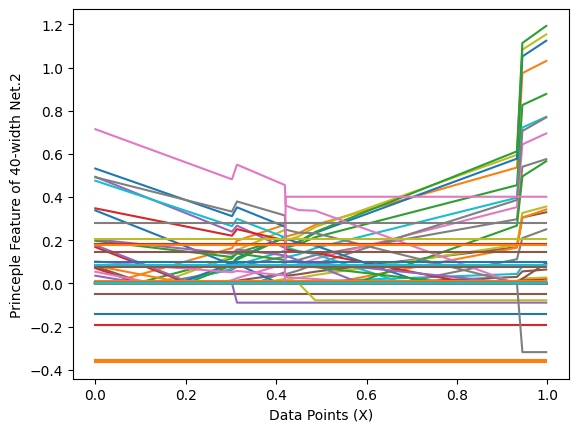

In [84]:
from tkinter.tix import X_REGION


def compute_svd_plot_features_two_net(X, y, X_test, y_test, net, label=''):
    width = net[0].out_features #the width is the number of hidden units.
    # gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    # X = sorted(X)
    for x in X:
        model = net
        y = model(to_torch(x))
        y.backward()
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
        model.zero_grad()

    # net 1
    feature_matrix_net1, feature_matrix_net2 = [], []
    for w_n in gradient_collect:
        if '0.weight' in w_n or '1.weight' in w_n or '0.bias' in w_n or '1.bais' in w_n:
            feature_matrix_net1.append( gradient_collect[w_n]['y'] )
        if '2.weight' in w_n or '2.weight' in w_n or '3.bias' in w_n or '3.bais' in w_n:
            feature_matrix_net2.append( gradient_collect[w_n]['y'] )
    feature_matrix_net1 = np.array( feature_matrix_net1 ).T
    print(feature_matrix_net1.shape)
    u1, s1, vh1 = np.linalg.svd(np.array( feature_matrix_net1 ), full_matrices=False)
    plt.scatter(np.arange(s1.shape[0]), s1, c='darkorange', s=40.0, label=f'singular values net.1')

    feature_matrix_net2 = np.array( feature_matrix_net2 ).T
    print(feature_matrix_net2.shape)
    u2, s2, vh2 = np.linalg.svd(np.array( feature_matrix_net2 ), full_matrices=False)
    plt.scatter(np.arange(s1.shape[0]), s2, s=40.0, label=f'singular values net.2')

    plt.legend()
    plt.show()


    # construct more training matrix 
    princple_feature_net1 = feature_matrix_net1 @ vh1
    for w_idx in range(feature_matrix_net1.shape[1]):
        plt.plot( X, feature_matrix_net1.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net.1')
    # plt.legend()
    plt.show()

    princple_feature_net2 = feature_matrix_net2 @ vh2
    for w_idx in range(feature_matrix_net2.shape[1]):
        plt.plot( X, feature_matrix_net2.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net.2')
    # plt.legend()
    plt.show()

# initializations = ['he', 'normal', 'xavier']
widths = [10, 20, 40]
for width in widths:

    # Define a 1-hidden layer ReLU nonlinearity network
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1),
                        nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1),)

    print(net)
    # Get trainable parameters
    weights_all = list(net.parameters())
    # Get the output weights alone
    # weights_out = weights_all[2:]
    # Adjust initial biases so elbows are in [0,1]
    elbows = np.sort(np.random.rand(width))
#     print("Elbows located at:")
#     print(elbows)
    new_biases = -elbows * to_numpy(weights_all[0]).ravel()
    weights_all[1].data = to_torch(new_biases)

    torch.nn.init.kaiming_normal_(net[3].weight, nonlinearity='relu')
    torch.nn.init.kaiming_normal_(net[5].weight, nonlinearity='relu')

    print(weights_all[5].data.shape, torch.nn.init.xavier_normal_(net[3].bias.unsqueeze(0)).shape)
    print(weights_all[7].data.shape, torch.nn.init.xavier_normal_(net[5].bias.unsqueeze(0)).shape)
    weights_all[5].data = torch.nn.init.xavier_normal_(net[3].bias.unsqueeze(0)).squeeze(0)
    weights_all[7].data = torch.nn.init.xavier_normal_(net[5].bias.unsqueeze(0)).squeeze(0)

    compute_svd_plot_features_two_net(X, y, X_test, y_test, net)


    